In [1]:
behavefn = 'data/data_MWQ_session_preprocessed.npy'
rscorrfn = 'data/data_cross_corr_Bzdok_DMN16_preprocessed.npy'

from os.path import expanduser
import numpy as np
%matplotlib inline
from funlib_scca import *

behavioral_data = np.load(expanduser(behavefn))
rest_data = np.load(expanduser(rscorrfn))
subject_subset = behavioral_data[:, 0].astype('i4') - 1

penFC = 0.3
penMW_5 = 0.5

n_iter = 1000
n_components = 13

session_data = behavioral_data[:,1:40]
X = rest_data[subject_subset,:]
Y = behavioral_data[:,40:]
u, v = SCCA_r(X, Y, n_components, penFC, penMW_5)
corr = (np.corrcoef(np.dot(X,u).T,np.dot(Y,v).T)[n_components:, 0:n_components]).diagonal()

# LODO

In [2]:
# Restart the random seed
np.random.seed(9999)
np.random.set_state(np.random.get_state())

session_data = behavioral_data[:,1:40]

LODOInd = np.random.randint(1,4, size=(n_iter, session_data.shape[0]))
corr_master = np.zeros((n_components, n_iter))

for n, k in enumerate(LODOInd):
    resample = np.zeros((session_data.shape[0], n_components))
    for i, drop in enumerate(k):
        cur_subj = session_data[i,:].reshape((3, n_components))
        # drop session
        cur_data = np.delete(cur_subj, drop - 1, 0)
        cur_data = np.mean(cur_data, axis=0)
        resample[i,:] = cur_data
        
    data_imp = imputedata(resample, 'mean', missing=True) #impute outlier

    S = data_imp.sum(axis=0) / data_imp.shape[0]
    data_imp -= S[np.newaxis, :]
    var = (data_imp ** 2).sum(axis=0)
    var[var == 0] = 1
    data_imp /= var
    
    cur_Y = data_imp
    u, v = SCCA_r(X, cur_Y, n_components, penFC, penMW_5)
    cur_cors = (np.corrcoef(np.dot(X,u).T,np.dot(cur_Y,v).T)[n_components:, 0:n_components]).diagonal()
    corr_master[:,n] = cur_cors 

In [3]:
# confidnece interval
alpha = 0.05
ind_low = int(n_iter * alpha / 2)
ind_high = int(n_iter - n_iter * alpha / 2)

# sort the canonical correlation score
corr_master.sort(axis=1) 

ci_corr =  (corr_master[:,ind_low], corr_master[:,ind_high])
np.set_printoptions(precision=3)
print('Sum of Cannonical Correlation Coefficent: %s' %str(corr.sum()))
print('Confident interval: 95%')
print('Low: %s'%str(ci_corr[0].sum()))
print('High: %s'%str(ci_corr[1].sum()))

Sum of Cannonical Correlation Coefficent: 4.23756694571
Confident interval: 95%
Low: 2.98792469083
High: 5.24865835135


In [4]:
theta_cv = np.sum(corr_master, axis=0) #this is the stats of interest
var_cv = ((theta_cv - (theta_cv.sum() / n_iter)) ** 2).sum()
sem_cv = np.sqrt( var_cv/ (n_iter - 1) )

# Bootstrapping

In [5]:
# Restart the random seed
np.random.seed(9999)
np.random.set_state(np.random.get_state())

from numpy.random import randint
# select a random index
bootsInd = randint(X.shape[0], size=(n_iter, X.shape[0]))
corr_master = np.zeros((n_components, n_iter))
for i, I in enumerate(bootsInd):
    cur_X = X[I,:]
    cur_Y = Y[I,:]
    u, v= SCCA_r(cur_X,cur_Y, n_components, penFC, penMW_5) # run SCCA
    cur_cors = (np.corrcoef(np.dot(cur_X ,u).T,np.dot(cur_Y ,v).T)[n_components:, 0:n_components]).diagonal()
    corr_master[:,i] = cur_cors 

In [6]:
#sort the canonical correlation score
corr_master.sort(axis=1)

# confidnece interval
alpha = 0.05
ind_low = int(n_iter*alpha/2)
ind_high = int(n_iter - n_iter*alpha/2)
ci_corr =  (corr_master[:,ind_low], corr_master[:,ind_high])
np.set_printoptions(precision=3)
print('Sum of Cannonical Correlation Coefficent: %s' %str(corr.sum()))
print('Confident interval: 95%')
print('Low: %s'%str(ci_corr[0].sum()))
print('High: %s'%str(ci_corr[1].sum()))

Sum of Cannonical Correlation Coefficent: 4.23756694571
Confident interval: 95%
Low: -0.187081919459
High: 6.81397853621


In [7]:
theta_boots = np.sum(corr_master, axis=0) #this is the stats of interest
var_boots = ((theta_boots - (theta_boots.sum() / n_iter)) ** 2).sum()
sem_boots = np.sqrt( var_boots/ (n_iter - 1) )

# Plot

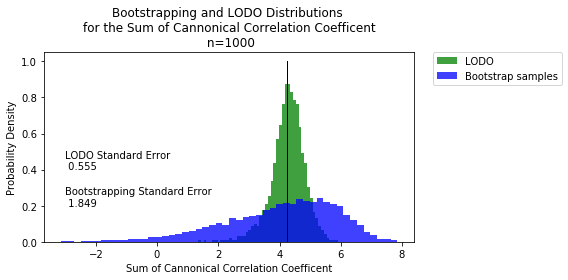

In [8]:
import matplotlib.patches as mpatches

fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(theta_cv, bins=50, normed=1, facecolor='green', alpha=0.75, label='LODO') 
plt.hist(theta_boots, bins=50, normed=1, facecolor='blue', alpha=0.75, label='Bootstrap samples')  
org = corr.sum()
plt.plot([org, org], [0, 1], 'k-', lw=1)

ax.set_ylabel('Probability Density')
ax.set_xlabel('Sum of Cannonical Correlation Coefficent')

# plt.legend(handles=[green_patch, blue_patch])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax.text(-3, .4, 'LODO Standard Error\n %1.3f' %sem_cv)
ax.text(-3, .2, 'Bootstrapping Standard Error\n %1.3f' %sem_boots)

plt.title('Bootstrapping and LODO Distributions \nfor the Sum of Cannonical Correlation Coefficent\n n=1000')

plt.tight_layout()
plt.savefig('Results/LODO_Boots_hist_n1000.png', dpi=300, transparent=True, bbox_inches='tight')
plt.show()